In [12]:
import pandas
import matplotlib as mpl
import xarray as xr
import numpy as np
from math import pi
import datetime as dt
import geopy.distance

def cal_dist(ds):
    lons = ds.lon.values
    lats = ds.lat.values
    ilen_lats = len(lats)
    dx=[0]*len(lats)
    dy=[0]*len(lats)
    dx_grid = np.empty([len(lats),len(lons)])    
    dy_grid = np.empty([len(lats),len(lons)])    
    for j in range(0,len(lats)):
        i=10 #just a random lon
        coords_1 = (lats[j], lons[i-1])  #cpr sample location
        coords_2 = (lats[j], lons[i])  #eddy location
        arclen_temp = geopy.distance.geodesic(coords_1, coords_2).m   
        for i in range(1,len(lons)-1):
            dx[j]=arclen_temp
    for j in range(1,len(lats)):
        i=10 #just a random lon
        coords_1 = (lats[j], lons[i])  #cpr sample location
        coords_2 = (lats[j-1], lons[i])  #eddy location
        arclen_temp = geopy.distance.geodesic(coords_1, coords_2).m       
        dy[j]=arclen_temp
    j=0
    i=10 #just a random lon
    coords_1 = (lats[j], lons[i])  #cpr sample location
    coords_2 = (lats[j+1], lons[i])  #eddy location
    arclen_temp = geopy.distance.geodesic(coords_1, coords_2).m       
    dy[j]=arclen_temp
    for i in range(0,len(lons)):
        for j in range(0,len(lats)):
            dx_grid[j,i]=dx[j]
            dy_grid[j,i]=dy[j]
    datax = xr.DataArray(dx_grid, coords={'lat': ds.lat,'lon':ds.lon}, dims=('lat', 'lon'))
    datay = xr.DataArray(dy_grid, coords={'lat': ds.lat,'lon':ds.lon}, dims=('lat', 'lon'))
    ds['dx_grid']=datax
    ds['dy_grid']=datay
    return ds


def wrf_vort( U, V, dx,dy ):
    """Calculate the relative vorticity given the U and V vector components in m/s
    and the grid spacing dx in meters.
    U and V must be the same shape.
    ---------------------
    U (numpy.ndarray): ndarray of U vector values in m/s
    V (numpy.ndarray): ndarray of V vector values in m/s
    dx (float or int): float or integer of U and V grispacing in meters
    ---------------------
    returns:
        numpy.ndarray of vorticity values s^-1 same shape as U and V
    """
#    assert U.shape == V.shape, 'Arrays are different shapes. They must be the same shape.'
    
    du = np.gradient( U )
    dv = np.gradient( V )
    return ( dv[-1]/dx - du[-2]/dy )

dir_data='F:/data/sat_data/ccmp/v02.0/'
def get_ccmp_filename_daily(lyr,idyjl):
    dir_data='F:/data/sat_data/ccmp/v02.0/'
    d = dt.date(lyr,1,1) + dt.timedelta(idyjl - 1)
    syr, smon, sdym =str(d.year).zfill(4), str(d.month).zfill(2), str(d.day).zfill(2)
    filename = dir_data + 'Y' + syr + '/M' + smon + '/CCMP_Wind_Analysis_' + syr + smon + sdym + '_V02.0_L3.0_RSS.nc'
    if lyr>=2018:
        filename = dir_data + 'Y' + syr + '/M' + smon + '/CCMP_RT_Wind_Analysis_' + syr + smon + sdym + '_V02.0_L3.0_RSS.nc'
    return filename
def get_ccmp_filename_month_new(lyr):
    dir_data='F:/data/sat_data/ccmp/v02.0/monthly/'
    syr, smon =str(lyr).zfill(4), str(imon).zfill(2)
    filename = dir_data + 'CCMP_Wind_Analysis_' + syr + '_V02.0_L3.0_RSS.nc'
    return filename

In [13]:
lyr=2000
filename = get_ccmp_filename_daily(2000,1)
ds = xr.open_dataset(filename,drop_variables='nobs')
ds['spd']=(ds.uwnd**2+ds.vwnd**2)**.5
ds['dir']=np.arctan2(ds.vwnd,ds.uwnd)* 180./pi
ds = ds.rename({'longitude':'lon','latitude':'lat'})
print(ds)
ds.close()

<xarray.Dataset>
Dimensions:  (lat: 628, lon: 1440, time: 4)
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * lat      (lat) float32 -78.375 -78.125 -77.875 ... 77.875 78.125 78.375
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T18:00:00
Data variables:
    uwnd     (time, lat, lon) float32 2.101699 2.131792 ... -9.585934 -9.500353
    vwnd     (time, lat, lon) float32 -2.6582468 -2.64885 ... 10.275465
    spd      (time, lat, lon) float32 3.3887188 3.4001389 ... 13.994352
    dir      (time, lat, lon) float32 -51.668915 -51.17292 ... 132.75545
Attributes:
    contact:                    Remote Sensing Systems, support@remss.com
    Conventions:                CF-1.6
    data_structure:             grid
    title:                      RSS CCMP V2.0 derived surface winds (Level 3.0)
    history:                    20160212T034001ZZ - netCDF generated from ori...
    description:                RSS VAM 6-hour analyses starting 

In [ ]:
from os.path import exists
import os
#make cmc monthly average ssts
#start from daily ratehr than use RSS monthly averages since want spd and dir not averaged
for lyr in range(1989,2019):
    ds_mnth=[]
    for imon in range(1,13):
        init = 0
        for idyjl in range(1,366):
            d = dt.date(lyr,1,1) + dt.timedelta(idyjl - 1)
            if d.month!=imon:
                continue
            filename = get_ccmp_filename_daily(lyr,idyjl)
            if not os.path.exists(filename):  
                continue
            print(filename)
            ds = xr.open_dataset(filename,drop_variables='nobs')
            ds['spd']=(ds.uwnd**2+ds.vwnd**2)**.5
            ds['dir']=np.arctan2(ds.vwnd,ds.uwnd)* 180./pi
            ds = ds.rename({'longitude':'lon','latitude':'lat'})
            ds.close()
#now calculate relative vorticity
            ds= cal_dist(ds)
            dvort = []
            init_vort = 0
            for i in range(0,4):
                dvort = wrf_vort( ds.uwnd[i,:,:], ds.vwnd[i,:,:], ds.dx_grid,ds.dy_grid)
                if init_vort==0:
                    ds_vort = dvort
                    init_vort = 1
                else:
                    ds_vort = xr.concat([ds_vort,dvort],dim = 'time')
            ds['rel_vorticity']=ds_vort
            if init==0:
                ds_sum = ds
                init = 1
            else:
                ds_sum = xr.concat([ds_sum,ds],dim = 'time')
            #print(idyjl,ds_sum.dims)
        ds_clim2 = ds_sum.resample(time='M').mean()    
        ds_mnth.append(ds_clim2)
    combined = xr.concat(ds_mnth, dim='time')
    filename = get_ccmp_filename_month_new(lyr)
    combined.to_netcdf(filename)
    

F:/data/sat_data/ccmp/v02.0/Y1989/M01/CCMP_Wind_Analysis_19890101_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M01/CCMP_Wind_Analysis_19890102_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M01/CCMP_Wind_Analysis_19890103_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M01/CCMP_Wind_Analysis_19890104_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M01/CCMP_Wind_Analysis_19890105_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M01/CCMP_Wind_Analysis_19890106_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M01/CCMP_Wind_Analysis_19890107_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M01/CCMP_Wind_Analysis_19890108_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M01/CCMP_Wind_Analysis_19890109_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M01/CCMP_Wind_Analysis_19890110_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M01/CCMP_Wind_Analysis_19890111_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M01/CCMP_Wind_Analysis_19890112_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1989/M04/CCMP_Wind_Analysis_19890412_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M04/CCMP_Wind_Analysis_19890413_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M04/CCMP_Wind_Analysis_19890414_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M04/CCMP_Wind_Analysis_19890415_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M04/CCMP_Wind_Analysis_19890416_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M04/CCMP_Wind_Analysis_19890417_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M04/CCMP_Wind_Analysis_19890418_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M04/CCMP_Wind_Analysis_19890419_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M04/CCMP_Wind_Analysis_19890420_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M04/CCMP_Wind_Analysis_19890421_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M04/CCMP_Wind_Analysis_19890422_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M04/CCMP_Wind_Analysis_19890423_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1989/M07/CCMP_Wind_Analysis_19890730_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M07/CCMP_Wind_Analysis_19890731_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M08/CCMP_Wind_Analysis_19890801_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M08/CCMP_Wind_Analysis_19890802_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M08/CCMP_Wind_Analysis_19890803_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M08/CCMP_Wind_Analysis_19890804_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M08/CCMP_Wind_Analysis_19890805_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M08/CCMP_Wind_Analysis_19890806_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M08/CCMP_Wind_Analysis_19890807_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M08/CCMP_Wind_Analysis_19890808_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M08/CCMP_Wind_Analysis_19890809_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M08/CCMP_Wind_Analysis_19890810_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1989/M11/CCMP_Wind_Analysis_19891105_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M11/CCMP_Wind_Analysis_19891106_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M11/CCMP_Wind_Analysis_19891107_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M11/CCMP_Wind_Analysis_19891108_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M11/CCMP_Wind_Analysis_19891109_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M11/CCMP_Wind_Analysis_19891110_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M11/CCMP_Wind_Analysis_19891111_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M11/CCMP_Wind_Analysis_19891112_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M11/CCMP_Wind_Analysis_19891113_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M11/CCMP_Wind_Analysis_19891114_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M11/CCMP_Wind_Analysis_19891115_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1989/M11/CCMP_Wind_Analysis_19891116_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1990/M02/CCMP_Wind_Analysis_19900211_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M02/CCMP_Wind_Analysis_19900212_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M02/CCMP_Wind_Analysis_19900213_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M02/CCMP_Wind_Analysis_19900214_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M02/CCMP_Wind_Analysis_19900215_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M02/CCMP_Wind_Analysis_19900216_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M02/CCMP_Wind_Analysis_19900217_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M02/CCMP_Wind_Analysis_19900218_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M02/CCMP_Wind_Analysis_19900219_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M02/CCMP_Wind_Analysis_19900220_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M02/CCMP_Wind_Analysis_19900221_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M02/CCMP_Wind_Analysis_19900222_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1990/M05/CCMP_Wind_Analysis_19900520_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M05/CCMP_Wind_Analysis_19900521_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M05/CCMP_Wind_Analysis_19900522_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M05/CCMP_Wind_Analysis_19900523_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M05/CCMP_Wind_Analysis_19900524_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M05/CCMP_Wind_Analysis_19900525_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M05/CCMP_Wind_Analysis_19900526_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M05/CCMP_Wind_Analysis_19900527_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M05/CCMP_Wind_Analysis_19900528_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M05/CCMP_Wind_Analysis_19900529_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M05/CCMP_Wind_Analysis_19900530_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M05/CCMP_Wind_Analysis_19900531_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1990/M08/CCMP_Wind_Analysis_19900826_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M08/CCMP_Wind_Analysis_19900827_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M08/CCMP_Wind_Analysis_19900828_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M08/CCMP_Wind_Analysis_19900829_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M08/CCMP_Wind_Analysis_19900830_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M08/CCMP_Wind_Analysis_19900831_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M09/CCMP_Wind_Analysis_19900901_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M09/CCMP_Wind_Analysis_19900902_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M09/CCMP_Wind_Analysis_19900903_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M09/CCMP_Wind_Analysis_19900904_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M09/CCMP_Wind_Analysis_19900905_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M09/CCMP_Wind_Analysis_19900906_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1990/M12/CCMP_Wind_Analysis_19901202_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M12/CCMP_Wind_Analysis_19901203_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M12/CCMP_Wind_Analysis_19901204_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M12/CCMP_Wind_Analysis_19901205_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M12/CCMP_Wind_Analysis_19901206_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M12/CCMP_Wind_Analysis_19901207_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M12/CCMP_Wind_Analysis_19901208_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M12/CCMP_Wind_Analysis_19901209_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M12/CCMP_Wind_Analysis_19901210_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M12/CCMP_Wind_Analysis_19901211_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M12/CCMP_Wind_Analysis_19901212_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1990/M12/CCMP_Wind_Analysis_19901213_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1991/M03/CCMP_Wind_Analysis_19910310_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M03/CCMP_Wind_Analysis_19910311_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M03/CCMP_Wind_Analysis_19910312_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M03/CCMP_Wind_Analysis_19910313_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M03/CCMP_Wind_Analysis_19910314_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M03/CCMP_Wind_Analysis_19910315_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M03/CCMP_Wind_Analysis_19910316_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M03/CCMP_Wind_Analysis_19910317_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M03/CCMP_Wind_Analysis_19910318_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M03/CCMP_Wind_Analysis_19910319_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M03/CCMP_Wind_Analysis_19910320_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M03/CCMP_Wind_Analysis_19910321_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1991/M06/CCMP_Wind_Analysis_19910616_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M06/CCMP_Wind_Analysis_19910617_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M06/CCMP_Wind_Analysis_19910618_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M06/CCMP_Wind_Analysis_19910619_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M06/CCMP_Wind_Analysis_19910620_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M06/CCMP_Wind_Analysis_19910621_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M06/CCMP_Wind_Analysis_19910622_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M06/CCMP_Wind_Analysis_19910623_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M06/CCMP_Wind_Analysis_19910624_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M06/CCMP_Wind_Analysis_19910625_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M06/CCMP_Wind_Analysis_19910626_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M06/CCMP_Wind_Analysis_19910627_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1991/M09/CCMP_Wind_Analysis_19910922_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M09/CCMP_Wind_Analysis_19910923_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M09/CCMP_Wind_Analysis_19910924_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M09/CCMP_Wind_Analysis_19910925_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M09/CCMP_Wind_Analysis_19910926_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M09/CCMP_Wind_Analysis_19910927_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M09/CCMP_Wind_Analysis_19910928_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M09/CCMP_Wind_Analysis_19910929_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M09/CCMP_Wind_Analysis_19910930_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M10/CCMP_Wind_Analysis_19911001_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M10/CCMP_Wind_Analysis_19911002_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M10/CCMP_Wind_Analysis_19911003_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1991/M12/CCMP_Wind_Analysis_19911229_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M12/CCMP_Wind_Analysis_19911230_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1991/M12/CCMP_Wind_Analysis_19911231_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M01/CCMP_Wind_Analysis_19920101_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M01/CCMP_Wind_Analysis_19920102_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M01/CCMP_Wind_Analysis_19920103_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M01/CCMP_Wind_Analysis_19920104_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M01/CCMP_Wind_Analysis_19920105_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M01/CCMP_Wind_Analysis_19920106_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M01/CCMP_Wind_Analysis_19920107_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M01/CCMP_Wind_Analysis_19920108_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M01/CCMP_Wind_Analysis_19920109_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1992/M04/CCMP_Wind_Analysis_19920405_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M04/CCMP_Wind_Analysis_19920406_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M04/CCMP_Wind_Analysis_19920407_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M04/CCMP_Wind_Analysis_19920408_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M04/CCMP_Wind_Analysis_19920409_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M04/CCMP_Wind_Analysis_19920410_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M04/CCMP_Wind_Analysis_19920411_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M04/CCMP_Wind_Analysis_19920412_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M04/CCMP_Wind_Analysis_19920413_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M04/CCMP_Wind_Analysis_19920414_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M04/CCMP_Wind_Analysis_19920415_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M04/CCMP_Wind_Analysis_19920416_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1992/M07/CCMP_Wind_Analysis_19920712_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M07/CCMP_Wind_Analysis_19920713_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M07/CCMP_Wind_Analysis_19920714_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M07/CCMP_Wind_Analysis_19920715_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M07/CCMP_Wind_Analysis_19920716_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M07/CCMP_Wind_Analysis_19920717_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M07/CCMP_Wind_Analysis_19920718_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M07/CCMP_Wind_Analysis_19920719_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M07/CCMP_Wind_Analysis_19920720_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M07/CCMP_Wind_Analysis_19920721_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M07/CCMP_Wind_Analysis_19920722_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M07/CCMP_Wind_Analysis_19920723_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1992/M10/CCMP_Wind_Analysis_19921018_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M10/CCMP_Wind_Analysis_19921019_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M10/CCMP_Wind_Analysis_19921020_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M10/CCMP_Wind_Analysis_19921021_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M10/CCMP_Wind_Analysis_19921022_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M10/CCMP_Wind_Analysis_19921023_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M10/CCMP_Wind_Analysis_19921024_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M10/CCMP_Wind_Analysis_19921025_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M10/CCMP_Wind_Analysis_19921026_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M10/CCMP_Wind_Analysis_19921027_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M10/CCMP_Wind_Analysis_19921028_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1992/M10/CCMP_Wind_Analysis_19921029_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1993/M01/CCMP_Wind_Analysis_19930125_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M01/CCMP_Wind_Analysis_19930126_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M01/CCMP_Wind_Analysis_19930127_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M01/CCMP_Wind_Analysis_19930128_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M01/CCMP_Wind_Analysis_19930129_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M01/CCMP_Wind_Analysis_19930130_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M01/CCMP_Wind_Analysis_19930131_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M02/CCMP_Wind_Analysis_19930201_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M02/CCMP_Wind_Analysis_19930202_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M02/CCMP_Wind_Analysis_19930203_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M02/CCMP_Wind_Analysis_19930204_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M02/CCMP_Wind_Analysis_19930205_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1993/M05/CCMP_Wind_Analysis_19930503_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M05/CCMP_Wind_Analysis_19930504_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M05/CCMP_Wind_Analysis_19930505_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M05/CCMP_Wind_Analysis_19930506_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M05/CCMP_Wind_Analysis_19930507_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M05/CCMP_Wind_Analysis_19930508_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M05/CCMP_Wind_Analysis_19930509_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M05/CCMP_Wind_Analysis_19930510_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M05/CCMP_Wind_Analysis_19930511_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M05/CCMP_Wind_Analysis_19930512_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M05/CCMP_Wind_Analysis_19930513_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M05/CCMP_Wind_Analysis_19930514_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1993/M08/CCMP_Wind_Analysis_19930809_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M08/CCMP_Wind_Analysis_19930810_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M08/CCMP_Wind_Analysis_19930811_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M08/CCMP_Wind_Analysis_19930812_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M08/CCMP_Wind_Analysis_19930813_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M08/CCMP_Wind_Analysis_19930814_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M08/CCMP_Wind_Analysis_19930815_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M08/CCMP_Wind_Analysis_19930816_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M08/CCMP_Wind_Analysis_19930817_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M08/CCMP_Wind_Analysis_19930818_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M08/CCMP_Wind_Analysis_19930819_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M08/CCMP_Wind_Analysis_19930820_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1993/M11/CCMP_Wind_Analysis_19931115_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M11/CCMP_Wind_Analysis_19931116_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M11/CCMP_Wind_Analysis_19931117_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M11/CCMP_Wind_Analysis_19931118_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M11/CCMP_Wind_Analysis_19931119_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M11/CCMP_Wind_Analysis_19931120_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M11/CCMP_Wind_Analysis_19931121_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M11/CCMP_Wind_Analysis_19931122_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M11/CCMP_Wind_Analysis_19931123_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M11/CCMP_Wind_Analysis_19931124_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M11/CCMP_Wind_Analysis_19931125_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1993/M11/CCMP_Wind_Analysis_19931126_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1994/M02/CCMP_Wind_Analysis_19940221_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M02/CCMP_Wind_Analysis_19940222_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M02/CCMP_Wind_Analysis_19940223_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M02/CCMP_Wind_Analysis_19940224_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M02/CCMP_Wind_Analysis_19940225_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M02/CCMP_Wind_Analysis_19940226_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M02/CCMP_Wind_Analysis_19940227_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M02/CCMP_Wind_Analysis_19940228_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M03/CCMP_Wind_Analysis_19940301_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M03/CCMP_Wind_Analysis_19940302_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M03/CCMP_Wind_Analysis_19940303_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M03/CCMP_Wind_Analysis_19940304_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1994/M05/CCMP_Wind_Analysis_19940530_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M05/CCMP_Wind_Analysis_19940531_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M06/CCMP_Wind_Analysis_19940601_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M06/CCMP_Wind_Analysis_19940602_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M06/CCMP_Wind_Analysis_19940603_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M06/CCMP_Wind_Analysis_19940604_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M06/CCMP_Wind_Analysis_19940605_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M06/CCMP_Wind_Analysis_19940606_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M06/CCMP_Wind_Analysis_19940607_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M06/CCMP_Wind_Analysis_19940608_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M06/CCMP_Wind_Analysis_19940609_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M06/CCMP_Wind_Analysis_19940610_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1994/M09/CCMP_Wind_Analysis_19940905_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M09/CCMP_Wind_Analysis_19940906_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M09/CCMP_Wind_Analysis_19940907_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M09/CCMP_Wind_Analysis_19940908_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M09/CCMP_Wind_Analysis_19940909_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M09/CCMP_Wind_Analysis_19940910_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M09/CCMP_Wind_Analysis_19940911_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M09/CCMP_Wind_Analysis_19940912_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M09/CCMP_Wind_Analysis_19940913_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M09/CCMP_Wind_Analysis_19940914_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M09/CCMP_Wind_Analysis_19940915_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M09/CCMP_Wind_Analysis_19940916_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1994/M12/CCMP_Wind_Analysis_19941212_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M12/CCMP_Wind_Analysis_19941213_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M12/CCMP_Wind_Analysis_19941214_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M12/CCMP_Wind_Analysis_19941215_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M12/CCMP_Wind_Analysis_19941216_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M12/CCMP_Wind_Analysis_19941217_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M12/CCMP_Wind_Analysis_19941218_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M12/CCMP_Wind_Analysis_19941219_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M12/CCMP_Wind_Analysis_19941220_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M12/CCMP_Wind_Analysis_19941221_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M12/CCMP_Wind_Analysis_19941222_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1994/M12/CCMP_Wind_Analysis_19941223_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1995/M03/CCMP_Wind_Analysis_19950320_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M03/CCMP_Wind_Analysis_19950321_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M03/CCMP_Wind_Analysis_19950322_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M03/CCMP_Wind_Analysis_19950323_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M03/CCMP_Wind_Analysis_19950324_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M03/CCMP_Wind_Analysis_19950325_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M03/CCMP_Wind_Analysis_19950326_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M03/CCMP_Wind_Analysis_19950327_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M03/CCMP_Wind_Analysis_19950328_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M03/CCMP_Wind_Analysis_19950329_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M03/CCMP_Wind_Analysis_19950330_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M03/CCMP_Wind_Analysis_19950331_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1995/M06/CCMP_Wind_Analysis_19950626_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M06/CCMP_Wind_Analysis_19950627_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M06/CCMP_Wind_Analysis_19950628_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M06/CCMP_Wind_Analysis_19950629_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M06/CCMP_Wind_Analysis_19950630_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M07/CCMP_Wind_Analysis_19950701_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M07/CCMP_Wind_Analysis_19950702_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M07/CCMP_Wind_Analysis_19950703_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M07/CCMP_Wind_Analysis_19950704_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M07/CCMP_Wind_Analysis_19950705_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M07/CCMP_Wind_Analysis_19950706_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M07/CCMP_Wind_Analysis_19950707_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1995/M10/CCMP_Wind_Analysis_19951002_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M10/CCMP_Wind_Analysis_19951003_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M10/CCMP_Wind_Analysis_19951004_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M10/CCMP_Wind_Analysis_19951005_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M10/CCMP_Wind_Analysis_19951006_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M10/CCMP_Wind_Analysis_19951007_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M10/CCMP_Wind_Analysis_19951008_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M10/CCMP_Wind_Analysis_19951009_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M10/CCMP_Wind_Analysis_19951010_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M10/CCMP_Wind_Analysis_19951011_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M10/CCMP_Wind_Analysis_19951012_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1995/M10/CCMP_Wind_Analysis_19951013_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1996/M01/CCMP_Wind_Analysis_19960108_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M01/CCMP_Wind_Analysis_19960109_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M01/CCMP_Wind_Analysis_19960110_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M01/CCMP_Wind_Analysis_19960111_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M01/CCMP_Wind_Analysis_19960112_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M01/CCMP_Wind_Analysis_19960113_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M01/CCMP_Wind_Analysis_19960114_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M01/CCMP_Wind_Analysis_19960115_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M01/CCMP_Wind_Analysis_19960116_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M01/CCMP_Wind_Analysis_19960117_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M01/CCMP_Wind_Analysis_19960118_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M01/CCMP_Wind_Analysis_19960119_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1996/M04/CCMP_Wind_Analysis_19960415_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M04/CCMP_Wind_Analysis_19960416_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M04/CCMP_Wind_Analysis_19960417_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M04/CCMP_Wind_Analysis_19960418_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M04/CCMP_Wind_Analysis_19960419_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M04/CCMP_Wind_Analysis_19960420_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M04/CCMP_Wind_Analysis_19960421_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M04/CCMP_Wind_Analysis_19960422_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M04/CCMP_Wind_Analysis_19960423_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M04/CCMP_Wind_Analysis_19960424_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M04/CCMP_Wind_Analysis_19960425_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M04/CCMP_Wind_Analysis_19960426_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1996/M07/CCMP_Wind_Analysis_19960722_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M07/CCMP_Wind_Analysis_19960723_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M07/CCMP_Wind_Analysis_19960724_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M07/CCMP_Wind_Analysis_19960725_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M07/CCMP_Wind_Analysis_19960726_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M07/CCMP_Wind_Analysis_19960727_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M07/CCMP_Wind_Analysis_19960728_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M07/CCMP_Wind_Analysis_19960729_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M07/CCMP_Wind_Analysis_19960730_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M07/CCMP_Wind_Analysis_19960731_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M08/CCMP_Wind_Analysis_19960801_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M08/CCMP_Wind_Analysis_19960802_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1996/M10/CCMP_Wind_Analysis_19961028_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M10/CCMP_Wind_Analysis_19961029_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M10/CCMP_Wind_Analysis_19961030_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M10/CCMP_Wind_Analysis_19961031_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M11/CCMP_Wind_Analysis_19961101_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M11/CCMP_Wind_Analysis_19961102_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M11/CCMP_Wind_Analysis_19961103_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M11/CCMP_Wind_Analysis_19961104_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M11/CCMP_Wind_Analysis_19961105_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M11/CCMP_Wind_Analysis_19961106_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M11/CCMP_Wind_Analysis_19961107_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1996/M11/CCMP_Wind_Analysis_19961108_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1997/M02/CCMP_Wind_Analysis_19970204_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M02/CCMP_Wind_Analysis_19970205_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M02/CCMP_Wind_Analysis_19970206_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M02/CCMP_Wind_Analysis_19970207_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M02/CCMP_Wind_Analysis_19970208_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M02/CCMP_Wind_Analysis_19970209_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M02/CCMP_Wind_Analysis_19970210_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M02/CCMP_Wind_Analysis_19970211_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M02/CCMP_Wind_Analysis_19970212_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M02/CCMP_Wind_Analysis_19970213_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M02/CCMP_Wind_Analysis_19970214_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M02/CCMP_Wind_Analysis_19970215_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1997/M05/CCMP_Wind_Analysis_19970513_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M05/CCMP_Wind_Analysis_19970514_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M05/CCMP_Wind_Analysis_19970515_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M05/CCMP_Wind_Analysis_19970516_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M05/CCMP_Wind_Analysis_19970517_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M05/CCMP_Wind_Analysis_19970518_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M05/CCMP_Wind_Analysis_19970519_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M05/CCMP_Wind_Analysis_19970520_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M05/CCMP_Wind_Analysis_19970521_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M05/CCMP_Wind_Analysis_19970522_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M05/CCMP_Wind_Analysis_19970523_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M05/CCMP_Wind_Analysis_19970524_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1997/M08/CCMP_Wind_Analysis_19970819_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M08/CCMP_Wind_Analysis_19970820_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M08/CCMP_Wind_Analysis_19970821_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M08/CCMP_Wind_Analysis_19970822_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M08/CCMP_Wind_Analysis_19970823_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M08/CCMP_Wind_Analysis_19970824_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M08/CCMP_Wind_Analysis_19970825_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M08/CCMP_Wind_Analysis_19970826_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M08/CCMP_Wind_Analysis_19970827_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M08/CCMP_Wind_Analysis_19970828_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M08/CCMP_Wind_Analysis_19970829_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M08/CCMP_Wind_Analysis_19970830_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1997/M11/CCMP_Wind_Analysis_19971125_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M11/CCMP_Wind_Analysis_19971126_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M11/CCMP_Wind_Analysis_19971127_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M11/CCMP_Wind_Analysis_19971128_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M11/CCMP_Wind_Analysis_19971129_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M11/CCMP_Wind_Analysis_19971130_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M12/CCMP_Wind_Analysis_19971201_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M12/CCMP_Wind_Analysis_19971202_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M12/CCMP_Wind_Analysis_19971203_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M12/CCMP_Wind_Analysis_19971204_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M12/CCMP_Wind_Analysis_19971205_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1997/M12/CCMP_Wind_Analysis_19971206_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1998/M03/CCMP_Wind_Analysis_19980303_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M03/CCMP_Wind_Analysis_19980304_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M03/CCMP_Wind_Analysis_19980305_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M03/CCMP_Wind_Analysis_19980306_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M03/CCMP_Wind_Analysis_19980307_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M03/CCMP_Wind_Analysis_19980308_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M03/CCMP_Wind_Analysis_19980309_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M03/CCMP_Wind_Analysis_19980310_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M03/CCMP_Wind_Analysis_19980311_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M03/CCMP_Wind_Analysis_19980312_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M03/CCMP_Wind_Analysis_19980313_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M03/CCMP_Wind_Analysis_19980314_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1998/M06/CCMP_Wind_Analysis_19980609_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M06/CCMP_Wind_Analysis_19980610_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M06/CCMP_Wind_Analysis_19980611_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M06/CCMP_Wind_Analysis_19980612_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M06/CCMP_Wind_Analysis_19980613_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M06/CCMP_Wind_Analysis_19980614_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M06/CCMP_Wind_Analysis_19980615_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M06/CCMP_Wind_Analysis_19980616_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M06/CCMP_Wind_Analysis_19980617_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M06/CCMP_Wind_Analysis_19980618_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M06/CCMP_Wind_Analysis_19980619_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M06/CCMP_Wind_Analysis_19980620_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1998/M09/CCMP_Wind_Analysis_19980915_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M09/CCMP_Wind_Analysis_19980916_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M09/CCMP_Wind_Analysis_19980917_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M09/CCMP_Wind_Analysis_19980918_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M09/CCMP_Wind_Analysis_19980919_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M09/CCMP_Wind_Analysis_19980920_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M09/CCMP_Wind_Analysis_19980921_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M09/CCMP_Wind_Analysis_19980922_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M09/CCMP_Wind_Analysis_19980923_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M09/CCMP_Wind_Analysis_19980924_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M09/CCMP_Wind_Analysis_19980925_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M09/CCMP_Wind_Analysis_19980926_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1998/M12/CCMP_Wind_Analysis_19981222_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M12/CCMP_Wind_Analysis_19981223_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M12/CCMP_Wind_Analysis_19981224_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M12/CCMP_Wind_Analysis_19981225_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M12/CCMP_Wind_Analysis_19981226_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M12/CCMP_Wind_Analysis_19981227_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M12/CCMP_Wind_Analysis_19981228_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M12/CCMP_Wind_Analysis_19981229_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M12/CCMP_Wind_Analysis_19981230_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1998/M12/CCMP_Wind_Analysis_19981231_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M01/CCMP_Wind_Analysis_19990101_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M01/CCMP_Wind_Analysis_19990102_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1999/M03/CCMP_Wind_Analysis_19990330_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M03/CCMP_Wind_Analysis_19990331_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M04/CCMP_Wind_Analysis_19990401_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M04/CCMP_Wind_Analysis_19990402_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M04/CCMP_Wind_Analysis_19990403_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M04/CCMP_Wind_Analysis_19990404_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M04/CCMP_Wind_Analysis_19990405_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M04/CCMP_Wind_Analysis_19990406_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M04/CCMP_Wind_Analysis_19990407_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M04/CCMP_Wind_Analysis_19990408_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M04/CCMP_Wind_Analysis_19990409_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M04/CCMP_Wind_Analysis_19990410_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1999/M07/CCMP_Wind_Analysis_19990706_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M07/CCMP_Wind_Analysis_19990707_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M07/CCMP_Wind_Analysis_19990708_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M07/CCMP_Wind_Analysis_19990709_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M07/CCMP_Wind_Analysis_19990710_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M07/CCMP_Wind_Analysis_19990711_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M07/CCMP_Wind_Analysis_19990712_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M07/CCMP_Wind_Analysis_19990713_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M07/CCMP_Wind_Analysis_19990714_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M07/CCMP_Wind_Analysis_19990715_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M07/CCMP_Wind_Analysis_19990716_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M07/CCMP_Wind_Analysis_19990717_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y1999/M10/CCMP_Wind_Analysis_19991012_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M10/CCMP_Wind_Analysis_19991013_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M10/CCMP_Wind_Analysis_19991014_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M10/CCMP_Wind_Analysis_19991015_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M10/CCMP_Wind_Analysis_19991016_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M10/CCMP_Wind_Analysis_19991017_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M10/CCMP_Wind_Analysis_19991018_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M10/CCMP_Wind_Analysis_19991019_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M10/CCMP_Wind_Analysis_19991020_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M10/CCMP_Wind_Analysis_19991021_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M10/CCMP_Wind_Analysis_19991022_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y1999/M10/CCMP_Wind_Analysis_19991023_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2000/M01/CCMP_Wind_Analysis_20000118_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M01/CCMP_Wind_Analysis_20000119_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M01/CCMP_Wind_Analysis_20000120_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M01/CCMP_Wind_Analysis_20000121_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M01/CCMP_Wind_Analysis_20000122_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M01/CCMP_Wind_Analysis_20000123_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M01/CCMP_Wind_Analysis_20000124_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M01/CCMP_Wind_Analysis_20000125_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M01/CCMP_Wind_Analysis_20000126_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M01/CCMP_Wind_Analysis_20000127_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M01/CCMP_Wind_Analysis_20000128_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M01/CCMP_Wind_Analysis_20000129_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2000/M04/CCMP_Wind_Analysis_20000425_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M04/CCMP_Wind_Analysis_20000426_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M04/CCMP_Wind_Analysis_20000427_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M04/CCMP_Wind_Analysis_20000428_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M04/CCMP_Wind_Analysis_20000429_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M04/CCMP_Wind_Analysis_20000430_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M05/CCMP_Wind_Analysis_20000501_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M05/CCMP_Wind_Analysis_20000502_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M05/CCMP_Wind_Analysis_20000503_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M05/CCMP_Wind_Analysis_20000504_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M05/CCMP_Wind_Analysis_20000505_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M05/CCMP_Wind_Analysis_20000506_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2000/M08/CCMP_Wind_Analysis_20000801_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M08/CCMP_Wind_Analysis_20000802_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M08/CCMP_Wind_Analysis_20000803_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M08/CCMP_Wind_Analysis_20000804_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M08/CCMP_Wind_Analysis_20000805_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M08/CCMP_Wind_Analysis_20000806_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M08/CCMP_Wind_Analysis_20000807_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M08/CCMP_Wind_Analysis_20000808_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M08/CCMP_Wind_Analysis_20000809_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M08/CCMP_Wind_Analysis_20000810_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M08/CCMP_Wind_Analysis_20000811_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M08/CCMP_Wind_Analysis_20000812_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2000/M11/CCMP_Wind_Analysis_20001107_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M11/CCMP_Wind_Analysis_20001108_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M11/CCMP_Wind_Analysis_20001109_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M11/CCMP_Wind_Analysis_20001110_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M11/CCMP_Wind_Analysis_20001111_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M11/CCMP_Wind_Analysis_20001112_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M11/CCMP_Wind_Analysis_20001113_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M11/CCMP_Wind_Analysis_20001114_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M11/CCMP_Wind_Analysis_20001115_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M11/CCMP_Wind_Analysis_20001116_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M11/CCMP_Wind_Analysis_20001117_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2000/M11/CCMP_Wind_Analysis_20001118_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2001/M02/CCMP_Wind_Analysis_20010214_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M02/CCMP_Wind_Analysis_20010215_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M02/CCMP_Wind_Analysis_20010216_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M02/CCMP_Wind_Analysis_20010217_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M02/CCMP_Wind_Analysis_20010218_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M02/CCMP_Wind_Analysis_20010219_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M02/CCMP_Wind_Analysis_20010220_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M02/CCMP_Wind_Analysis_20010221_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M02/CCMP_Wind_Analysis_20010222_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M02/CCMP_Wind_Analysis_20010223_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M02/CCMP_Wind_Analysis_20010224_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M02/CCMP_Wind_Analysis_20010225_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2001/M05/CCMP_Wind_Analysis_20010523_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M05/CCMP_Wind_Analysis_20010524_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M05/CCMP_Wind_Analysis_20010525_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M05/CCMP_Wind_Analysis_20010526_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M05/CCMP_Wind_Analysis_20010527_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M05/CCMP_Wind_Analysis_20010528_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M05/CCMP_Wind_Analysis_20010529_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M05/CCMP_Wind_Analysis_20010530_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M05/CCMP_Wind_Analysis_20010531_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M06/CCMP_Wind_Analysis_20010601_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M06/CCMP_Wind_Analysis_20010602_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M06/CCMP_Wind_Analysis_20010603_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2001/M08/CCMP_Wind_Analysis_20010829_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M08/CCMP_Wind_Analysis_20010830_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M08/CCMP_Wind_Analysis_20010831_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M09/CCMP_Wind_Analysis_20010901_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M09/CCMP_Wind_Analysis_20010902_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M09/CCMP_Wind_Analysis_20010903_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M09/CCMP_Wind_Analysis_20010904_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M09/CCMP_Wind_Analysis_20010905_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M09/CCMP_Wind_Analysis_20010906_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M09/CCMP_Wind_Analysis_20010907_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M09/CCMP_Wind_Analysis_20010908_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M09/CCMP_Wind_Analysis_20010909_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2001/M12/CCMP_Wind_Analysis_20011205_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M12/CCMP_Wind_Analysis_20011206_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M12/CCMP_Wind_Analysis_20011207_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M12/CCMP_Wind_Analysis_20011208_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M12/CCMP_Wind_Analysis_20011209_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M12/CCMP_Wind_Analysis_20011210_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M12/CCMP_Wind_Analysis_20011211_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M12/CCMP_Wind_Analysis_20011212_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M12/CCMP_Wind_Analysis_20011213_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M12/CCMP_Wind_Analysis_20011214_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M12/CCMP_Wind_Analysis_20011215_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2001/M12/CCMP_Wind_Analysis_20011216_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2002/M03/CCMP_Wind_Analysis_20020313_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M03/CCMP_Wind_Analysis_20020314_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M03/CCMP_Wind_Analysis_20020315_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M03/CCMP_Wind_Analysis_20020316_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M03/CCMP_Wind_Analysis_20020317_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M03/CCMP_Wind_Analysis_20020318_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M03/CCMP_Wind_Analysis_20020319_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M03/CCMP_Wind_Analysis_20020320_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M03/CCMP_Wind_Analysis_20020321_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M03/CCMP_Wind_Analysis_20020322_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M03/CCMP_Wind_Analysis_20020323_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M03/CCMP_Wind_Analysis_20020324_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2002/M06/CCMP_Wind_Analysis_20020619_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M06/CCMP_Wind_Analysis_20020620_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M06/CCMP_Wind_Analysis_20020621_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M06/CCMP_Wind_Analysis_20020622_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M06/CCMP_Wind_Analysis_20020623_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M06/CCMP_Wind_Analysis_20020624_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M06/CCMP_Wind_Analysis_20020625_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M06/CCMP_Wind_Analysis_20020626_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M06/CCMP_Wind_Analysis_20020627_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M06/CCMP_Wind_Analysis_20020628_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M06/CCMP_Wind_Analysis_20020629_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M06/CCMP_Wind_Analysis_20020630_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2002/M09/CCMP_Wind_Analysis_20020925_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M09/CCMP_Wind_Analysis_20020926_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M09/CCMP_Wind_Analysis_20020927_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M09/CCMP_Wind_Analysis_20020928_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M09/CCMP_Wind_Analysis_20020929_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M09/CCMP_Wind_Analysis_20020930_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M10/CCMP_Wind_Analysis_20021001_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M10/CCMP_Wind_Analysis_20021002_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M10/CCMP_Wind_Analysis_20021003_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M10/CCMP_Wind_Analysis_20021004_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M10/CCMP_Wind_Analysis_20021005_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2002/M10/CCMP_Wind_Analysis_20021006_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2003/M01/CCMP_Wind_Analysis_20030101_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M01/CCMP_Wind_Analysis_20030102_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M01/CCMP_Wind_Analysis_20030103_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M01/CCMP_Wind_Analysis_20030104_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M01/CCMP_Wind_Analysis_20030105_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M01/CCMP_Wind_Analysis_20030106_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M01/CCMP_Wind_Analysis_20030107_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M01/CCMP_Wind_Analysis_20030108_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M01/CCMP_Wind_Analysis_20030109_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M01/CCMP_Wind_Analysis_20030110_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M01/CCMP_Wind_Analysis_20030111_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M01/CCMP_Wind_Analysis_20030112_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2003/M04/CCMP_Wind_Analysis_20030409_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M04/CCMP_Wind_Analysis_20030410_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M04/CCMP_Wind_Analysis_20030411_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M04/CCMP_Wind_Analysis_20030412_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M04/CCMP_Wind_Analysis_20030413_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M04/CCMP_Wind_Analysis_20030414_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M04/CCMP_Wind_Analysis_20030415_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M04/CCMP_Wind_Analysis_20030416_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M04/CCMP_Wind_Analysis_20030417_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M04/CCMP_Wind_Analysis_20030418_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M04/CCMP_Wind_Analysis_20030419_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M04/CCMP_Wind_Analysis_20030420_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2003/M07/CCMP_Wind_Analysis_20030716_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M07/CCMP_Wind_Analysis_20030717_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M07/CCMP_Wind_Analysis_20030718_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M07/CCMP_Wind_Analysis_20030719_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M07/CCMP_Wind_Analysis_20030720_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M07/CCMP_Wind_Analysis_20030721_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M07/CCMP_Wind_Analysis_20030722_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M07/CCMP_Wind_Analysis_20030723_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M07/CCMP_Wind_Analysis_20030724_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M07/CCMP_Wind_Analysis_20030725_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M07/CCMP_Wind_Analysis_20030726_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M07/CCMP_Wind_Analysis_20030727_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2003/M10/CCMP_Wind_Analysis_20031022_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M10/CCMP_Wind_Analysis_20031023_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M10/CCMP_Wind_Analysis_20031024_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M10/CCMP_Wind_Analysis_20031025_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M10/CCMP_Wind_Analysis_20031026_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M10/CCMP_Wind_Analysis_20031027_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M10/CCMP_Wind_Analysis_20031028_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M10/CCMP_Wind_Analysis_20031029_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M10/CCMP_Wind_Analysis_20031030_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M10/CCMP_Wind_Analysis_20031031_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M11/CCMP_Wind_Analysis_20031101_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M11/CCMP_Wind_Analysis_20031102_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040128_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040129_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040130_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040131_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M02/CCMP_Wind_Analysis_20040201_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M02/CCMP_Wind_Analysis_20040202_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M02/CCMP_Wind_Analysis_20040203_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M02/CCMP_Wind_Analysis_20040204_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M02/CCMP_Wind_Analysis_20040205_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M02/CCMP_Wind_Analysis_20040206_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M02/CCMP_Wind_Analysis_20040207_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M02/CCMP_Wind_Analysis_20040208_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2004/M05/CCMP_Wind_Analysis_20040505_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M05/CCMP_Wind_Analysis_20040506_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M05/CCMP_Wind_Analysis_20040507_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M05/CCMP_Wind_Analysis_20040508_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M05/CCMP_Wind_Analysis_20040509_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M05/CCMP_Wind_Analysis_20040510_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M05/CCMP_Wind_Analysis_20040511_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M05/CCMP_Wind_Analysis_20040512_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M05/CCMP_Wind_Analysis_20040513_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M05/CCMP_Wind_Analysis_20040514_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M05/CCMP_Wind_Analysis_20040515_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M05/CCMP_Wind_Analysis_20040516_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040811_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040812_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040813_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040814_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040815_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040816_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040817_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040818_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040819_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040820_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040821_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040822_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041117_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041118_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041119_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041120_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041121_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041122_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041123_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041124_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041125_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041126_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041127_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041128_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050224_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050225_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050226_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050227_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050228_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050301_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050302_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050303_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050304_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050305_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050306_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050307_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2005/M06/CCMP_Wind_Analysis_20050602_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M06/CCMP_Wind_Analysis_20050603_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M06/CCMP_Wind_Analysis_20050604_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M06/CCMP_Wind_Analysis_20050605_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M06/CCMP_Wind_Analysis_20050606_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M06/CCMP_Wind_Analysis_20050607_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M06/CCMP_Wind_Analysis_20050608_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M06/CCMP_Wind_Analysis_20050609_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M06/CCMP_Wind_Analysis_20050610_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M06/CCMP_Wind_Analysis_20050611_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M06/CCMP_Wind_Analysis_20050612_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M06/CCMP_Wind_Analysis_20050613_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050908_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050909_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050910_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050911_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050912_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050913_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050914_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050915_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050916_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050917_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050918_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050919_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051215_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051216_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051217_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051218_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051219_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051220_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051221_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051222_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051223_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051224_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051225_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051226_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060323_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060324_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060325_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060326_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060327_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060328_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060329_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060330_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060331_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M04/CCMP_Wind_Analysis_20060401_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M04/CCMP_Wind_Analysis_20060402_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M04/CCMP_Wind_Analysis_20060403_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2006/M06/CCMP_Wind_Analysis_20060629_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M06/CCMP_Wind_Analysis_20060630_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060701_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060702_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060703_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060704_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060705_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060706_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060707_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060708_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060709_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060710_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061005_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061006_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061007_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061008_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061009_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061010_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061011_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061012_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061013_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061014_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061015_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061016_V02.0_L3.0

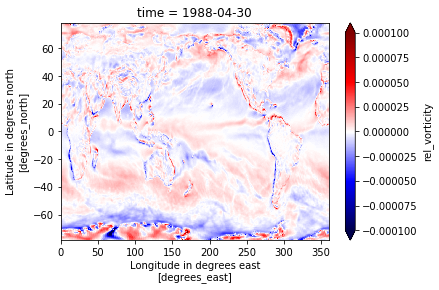

In [10]:
combined.rel_vorticity[3,:,:].plot(vmin=-.0001,vmax=.0001,cmap='seismic')

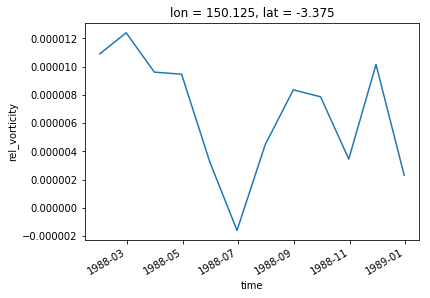

In [11]:
combined.rel_vorticity[:,300,600].plot()

combined

In [42]:
#make cmc climatology from monthly files
dir_data='F:/data/sat_data/ccmp/v02.0/monthly/'
for icase in range(0,3):
    if icase==0:
        iyr1,iyr2 = 1988,2000
    if icase==1:
        iyr1,iyr2 = 2000,2010
    if icase==2:
        iyr1,iyr2 = 2010,2018
    init = 0
    for lyr in range(iyr1,iyr2): 
        filename = get_ccmp_filename_month_new(lyr,12)
        ds = xr.open_dataset(filename)
        if init==0:
            ds_sum = ds
            init = 1
        else:
            ds_sum = xr.concat([ds_sum,ds],dim = 'time')
        print(lyr,ds_sum.dims)
    ds_sum2 = ds_sum.groupby('time.month').mean('time')
    fname_tem=dir_data + 'climatology_'+str(iyr1)+'_'+str(iyr2-1)+'_CCMP_Wind_Analysis_L3.0.nc'
    ds_sum2.to_netcdf(fname_tem)


FileNotFoundError: [Errno 2] No such file or directory: b'F:\\data\\sat_data\\ccmp\\v02.0\\monthly\\CCMP_Wind_Analysis_198812_V02.0_L3.0_RSS.nc'

In [8]:
dir_data='F:/data/sat_data/ccmp/v02.0/monthly/'
num_year = 2018-1988+1
num_year_file1 = 2000 - 1988 +1
num_year_file2 = 2010 - 2000 +1 
num_year_file3 = 2018 - 2011 +1
frac_file1 = num_year_file1 / num_year
frac_file2 = num_year_file2 / num_year
frac_file3 = num_year_file3 / num_year
fname_tem=dir_data + 'climatology_1988_2000_CCMP_Wind_Analysis_L3.0.nc'
print(fname_tem)
ds = xr.open_dataset(fname_tem)
ds_masked = ds.where(ds['mask'] == 1.) 
ds.close()
fname_tem=dir_data + 'climatology_2001_2010_CCMP_Wind_Analysis_L3.0.nc'
print(fname_tem)
ds = xr.open_dataset(fname_tem)
ds_masked2 = ds.where(ds['mask'] == 1.) 
#ds_sum = xr.concat([ds_masked2,ds_masked],dim = 'time')
ds.close()
fname_tem=dir_data + 'climatology_2011_2018_CCMP_Wind_Analysis_L3.0.nc'
print(fname_tem)
ds = xr.open_dataset(fname_tem)
ds_masked3 = ds.where(ds['mask'] == 1.) 
#ds_sum = xr.concat([ds_masked2,ds_masked],dim = 'time')
ds.close()
ds_ave = frac_file1*ds_masked + frac_file2*ds_masked2 + frac_file3*ds_masked3
#ds_sum = ds_sum.mean('time',skipna=True)
print(frac_file1+frac_file2,frac_file1,frac_file2)
fname_tem=dir_data + 'climatology_1992_2018_CCMP_Wind_Analysis_L3.0.nc'
print(fname_tem)
ds_ave.to_netcdf(fname_tem)

1988 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 12}))
1989 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 24}))
1990 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 36}))
1991 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 48}))
1992 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 60}))
1993 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 72}))
1994 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 84}))
1995 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 96}))
1996 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 108}))
1997 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 120}))
1998 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 132}))
1999 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 144}))
2000 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 156}))
2001 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 168}))
2002 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'ti

In [10]:
ds_sum2

<xarray.Dataset>
Dimensions:  (lat: 628, lon: 1440, month: 12)
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * lat      (lat) float32 -78.375 -78.125 -77.875 ... 77.875 78.125 78.375
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    uwnd     (month, lat, lon) float32 0.08409567 0.100546025 ... -1.2747644
    vwnd     (month, lat, lon) float32 -4.1172147 -4.152534 ... -3.2976847
    spd      (month, lat, lon) float32 4.419509 4.4540963 ... 8.421315 8.486904
    dir      (month, lat, lon) float32 -88.65275 -88.37244 ... -46.316708

In [9]:
#make cmc climatology from monthly files
init = 0
for lyr in range(2000,2018): #2017):
    fname_tem=str(lyr) + 'monthly_average_ccmp_V02.0_L3.5_RSS.nc'
    cmc_filename_out = dir_data + fname_tem
    ds = xr.open_dataset(cmc_filename_out)
    #ds.rename({'longitude':'lon','latitude':'lat'}, inplace = True)
    if init==0:
        ds_sum = ds
        init = 1
    else:
        ds_sum = xr.concat([ds_sum,ds],dim = 'time')
    print(lyr,ds_sum.dims)
ds_sum2 = ds_sum.groupby('time.month').mean('time')
#ds_sum = ds_sum.mean('time',skipna=True)
fname_tem='2000_2017_monthly_climatology_ccmp_V02.0_L3.5_RSS.nc'
cmc_filename_out = dir_data + fname_tem
ds_sum2.to_netcdf(cmc_filename_out)
 

2000 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 12}))
2001 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 24}))
2002 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 36}))
2003 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 48}))
2004 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 60}))
2005 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 72}))
2006 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 84}))
2007 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 96}))
2008 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 108}))
2009 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 120}))
2010 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 132}))
2011 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 144}))
2012 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 156}))
2013 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 168}))
2014 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'ti

In [ ]:
#change climatology lat lon from altitude longitude
fname_tem='monthly_climatology_ccmp_V02.0_L3.5_RSS.nc'
cmc_filename_out = dir_data + fname_tem
fname_tem='monthly_climatology_ccmp_V02.0_L3.5_RSSa.nc'
cmc_filename_outa = dir_data + fname_tem
ds = xr.open_dataset(cmc_filename_out)
ds.rename({'longitude':'lon','latitude':'lat'}, inplace = True)
ds.to_netcdf(cmc_filename_outa)
ds.close()



In [ ]:
ds

In [ ]:
#OLD CODE
#make ccmp monthly average ssts in annual file
for lyr in range(1988,2018): #2017):
    ds_mnth=[]
    for imon in range(1,13):
        filename = dir_data + 'Y' + str(lyr) + '/M' + str(imon).zfill(2) + '/CCMP_Wind_Analysis_' + str(lyr) + str(imon).zfill(2) + '_V02.0_L3.5_RSS.nc'
        ds = xr.open_dataset(filename)
        ds['spd']=(ds.uwnd**2+ds.vwnd**2)**.5
        ds['dir']=np.arctan2(ds.vwnd,ds.uwnd)* 180./pi
        ds = ds.rename({'longitude':'lon','latitude':'lat'})
        ds_mnth.append(ds)
        ds.close()
    combined = xr.concat(ds_mnth, dim='time')
    fname_tem= str(lyr) + 'monthly_average_ccmp_V02.0_L3.5_RSS.nc'
    cmc_filename_out = dir_data + fname_tem
    combined.to_netcdf(cmc_filename_out)